# Stan Examples

We use Stan for Metropolis sampling in problems which cannot be formulated in the context of Gibbs sampling (i.e. where a conditional posterior is known).

In [1]:
import stan

import nest_asyncio
nest_asyncio.apply()  

## Covid Timeseries Example

Based on the deterministic reporting (fixed bias) model, initially with a known R value

### Data Generation

In [2]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

from periodic_sampling.synthetic_data import RenewalModel, Reporter

100%|██████████| 100/100 [00:00<00:00, 126831.09it/s]


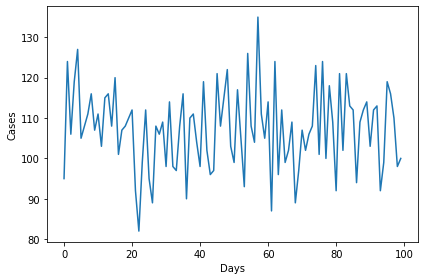

In [24]:
# Simulate Renewal Model
time_steps = 100; N_0 = 100; seed=42; R0 = 0.99
start_date = '07/01/2020'; bias_method = 'scale'

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first

np.random.seed(seed)
model = RenewalModel()
model.simulate(T=time_steps, N_0=N_0, R_0=0.99)
model.plot()

In [25]:
# Report unbiased and biased data
rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease

truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

### Inference Framework

In [26]:
import os

class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).
    Credit to randlet (https://github.com/facebook/prophet/issues/223).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

In [27]:
with open("fixed_bias_example.stan") as f:
    fixed_bias_code = f.read()

c_val = list(bias_df['Confirmed'])

fixed_bias_data = {
    "time_steps": len(c_val),
    "C": c_val,
    "R": 0.99,
    "serial_interval": RenewalModel(R0=None).serial_interval,
}
with suppress_stdout_stderr():
    posterior = stan.build(fixed_bias_code, data=fixed_bias_data, random_seed=2) 

Building...



Building: found in cache, done.Messages from stanc:
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.


In [28]:
bias_init_val = [1.0 for x in range(7)]
chain_num = 4
init_values = [{'alpha': bias_init_val} for _ in range(chain_num)]  # List of dict for each chain

fit = posterior.sample(num_chains=chain_num, num_samples=100, init=init_values)

Sampling:   0%
Sampling:   5% (200/4400)
Sampling:  14% (600/4400)
Sampling:  23% (1000/4400)
Sampling:  34% (1500/4400)
Sampling:  55% (2400/4400)
Sampling:  70% (3100/4400)
Sampling:  86% (3800/4400)
Sampling: 100% (4400/4400)
Sampling: 100% (4400/4400), done.
Messages received during sampling:
  Gradient evaluation took 0.000107 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.07 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/tmp/httpstan_7pjfedmb/model_ey3eegvv.stan', line 42, column 4 to column 23)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational M

In [29]:
df = fit.to_frame()
print(df.describe().T)

               count          mean       std           min           25%  \
parameters                                                                 
lp__           400.0  39780.284659  1.882396  39773.757574  39779.228668   
accept_stat__  400.0      0.888521  0.111001      0.455045      0.816825   
stepsize__     400.0      0.741953  0.023025      0.716310      0.720687   
treedepth__    400.0      2.670000  0.476095      1.000000      2.000000   
n_leapfrog__   400.0      5.920000  1.778062      3.000000      3.000000   
divergent__    400.0      0.000000  0.000000      0.000000      0.000000   
energy__       400.0 -39776.834179  2.623137 -39782.042315 -39778.679017   
alpha.1        400.0      0.581758  0.019816      0.521875      0.568630   
alpha.2        400.0      1.392989  0.028790      1.292905      1.374604   
alpha.3        400.0      1.090396  0.025257      1.013915      1.071523   
alpha.4        400.0      0.984995  0.024383      0.908535      0.967278   
alpha.5     